# Using docTR's standalone predictors

docTR’s `ocr_predictor` acts as a modular wrapper for its individual prediction models.
This notebook shows how to work with these models independently, which can be helpful if you don't need all the features of the `ocr_predictor`.
For instance, you might want to pair docTR's `detection_predictor` with a different recognition model.


In [51]:
# Install doctr
!pip3 install python-doctr[torch,viz]@git+https://github.com/mindee/doctr.git
# Restart runtime
exit()

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-cp6ycp_i/python-doctr_65bb59a58af6464198f54114012b4216
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-cp6ycp_i/python-doctr_65bb59a58af6464198f54114012b4216
  Resolved https://github.com/mindee/doctr.git to commit 7f21e76175cdb47c430b9c5a031a09686be94fb6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


: 

In [1]:
# Imports
import requests
import numpy as np
from matplotlib import pyplot as plt
import cv2

from doctr.models import detection_predictor, recognition_predictor, page_orientation_predictor, crop_orientation_predictor
from doctr.io import DocumentFile
from doctr.utils.geometry import detach_scores

/home/felix/anaconda3/envs/doctr-torch-notebooks/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define sample image urls

# Image of receipt
receipt = requests.get("https://github.com/mindee/doctr/releases/download/v0.3.0/mock_receipt.jpeg").content
receipt_image = cv2.imdecode(np.frombuffer(receipt, np.uint8), cv2.IMREAD_COLOR)

# Image of a word crop
word_crop = requests.get("https://github.com/mindee/doctr/releases/download/v0.5.1/word-crop.png").content
word_crop_image = cv2.imdecode(np.frombuffer(word_crop, np.uint8), cv2.IMREAD_COLOR)

## Detection predictor

The detection predictor can be used to detect text in an image.

/home/felix/anaconda3/envs/doctr-torch-notebooks/lib/python3.10/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = to

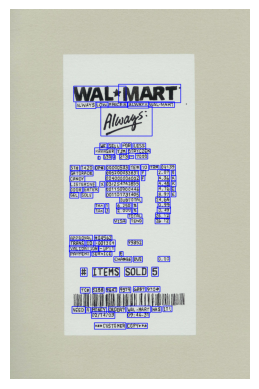

In [3]:
# Helper function to convert relative coordinates to absolute pixel values
def _to_absolute(geom, img_shape: tuple[int, int]) -> list[list[int]]:
    h, w = img_shape
    if len(geom) == 2:  # Assume straight pages = True -> [[xmin, ymin], [xmax, ymax]]
        (xmin, ymin), (xmax, ymax) = geom
        xmin, xmax = int(round(w * xmin)), int(round(w * xmax))
        ymin, ymax = int(round(h * ymin)), int(round(h * ymax))
        return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    else:  # For polygons, convert each point to absolute coordinates
        return [[int(point[0] * w), int(point[1] * h)] for point in geom]

# Define the detection predictor
det_predictor = detection_predictor(
    arch="db_resnet50",
    pretrained=True,
    assume_straight_pages=True,
    symmetric_pad=True,
    preserve_aspect_ratio=True,
    batch_size=1,
)  # .cuda().half()  # Uncomment this line if you have a GPU

# Define the postprocessing parameters (optional)
det_predictor.model.postprocessor.bin_thresh = 0.3
det_predictor.model.postprocessor.box_thresh = 0.1

# Load the document image
docs = DocumentFile.from_images([receipt])
results = det_predictor(docs)

for doc, res in zip(docs, results):
    img_shape = (doc.shape[0], doc.shape[1])
    # Detach the probability scores from the results
    detached_coords, prob_scores = detach_scores([res.get("words")])

    for i, coords in enumerate(detached_coords[0]):
        coords = coords.reshape(2, 2).tolist() if coords.shape == (4,) else coords.tolist()

        # Convert relative to absolute pixel coordinates
        points = np.array(_to_absolute(coords, img_shape), dtype=np.int32).reshape((-1, 1, 2))

        # Draw the bounding box on the image
        cv2.polylines(receipt_image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

%matplotlib inline
plt.axis('off')
plt.imshow(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB))

## Recognition predictor

The recognition predictor is used to recognize text from pre-cropped word images.

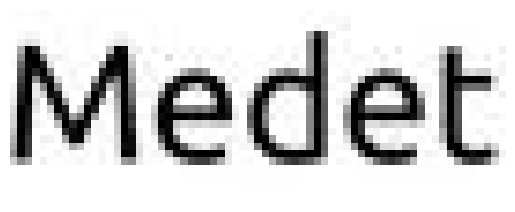

Recognized text: Medet 
with confidence: 1.00


In [4]:

# Load the word crop image
doc = DocumentFile.from_images([word_crop])
# Define the recognition predictor
rec_predictor = recognition_predictor(arch="parseq", pretrained=True, symmetric_pad=True, batch_size=1)  # .cuda().half()  # Uncomment this line if you have a GPU
result = rec_predictor(doc)

%matplotlib inline
plt.imshow(cv2.cvtColor(word_crop_image, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
print(f"Recognized text: {result[0][0]} \nwith confidence: {result[0][1]:.2f}")



## Orientation predictors

The orientation predictors can detect the **overall** orientation of a document image or word crop.
They return the general orientation —[0, 90, 180, -90 (270)]— along with the corresponding confidence score.

In [44]:

docs = DocumentFile.from_images([receipt])
page_orient_predictor = page_orientation_predictor(pretrained=True, batch_size=1)  # .cuda().half()  # Uncomment this line if you have a GPU
result = page_orient_predictor(docs)
print(f"general crop orientation: {result[1][0]} with confidence: {result[2][0]:.2f}")

crop = DocumentFile.from_images([word_crop])
crop_orient_predictor = crop_orientation_predictor(pretrained=True, batch_size=1)  # .cuda().half()  # Uncomment this line if you have a GPU
result = crop_orient_predictor(crop)
print(f"general crop orientation: {result[1][0]} with confidence: {result[2][0]:.2f}")

general crop orientation: 0 with confidence: 1.00
general crop orientation: 0 with confidence: 1.00


/home/felix/anaconda3/envs/doctr-torch-notebooks/lib/python3.10/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = to